# Analyzing authorship of tweets from Rihanna and Katy Perry using Claude

In [1]:
import os 
import sys
sys.path.append(os.path.abspath('..'))

In [2]:
import pickle
import pandas as pd
import numpy as np
import sklearn

In [3]:
from anthropic import Anthropic
from credentials import get_credentials_claude

API_KEY = get_credentials_claude()

client = Anthropic(api_key=API_KEY)


In [4]:
# Load data

# load training data
with open('./data/sampled_author_texts.pkl', 'rb') as f:
    training_data = pickle.load(f)

#load test data
with open('./data/twitter_test.pkl', 'rb') as f:
    test_data = pickle.load(f)

In [5]:
# Get a random tweet from the test set
random_tweet_text = test_data['content'].sample(n=1, random_state=42).values[0]
random_tweet_author = test_data.loc[test_data['content'] == random_tweet_text, 'author'].values[0]
print(random_tweet_text)
print(f"Author: {random_tweet_author}")


It's just beyond the vault. Discover room 7 of the #ANTIdiaRy at https://t.co/uJ0CLlhoaS https://t.co/povYOBn3Fm
Author: rihanna


In [6]:
# Create the template prompt

prompt = f"""
You are an expert in linguistic analysis and authorship attribution. Your task is to analyze authorship--i.e. idiolectal--markers that the \
texts reveal about their authors.


You will be provided with:
1. Training samples (tweets) from 2 different authors, Rihanna and Katy Perry
2. A new text whose author you need to identify between those two authors

Guideline for analysis:
- Just use state of the art techniques to attribute authorship

Rihanna's tweets:
{training_data['rihanna']}

Katy Perry's tweets:
{training_data['katyperry']}

New text to analyze:
{random_tweet_text}

Your answer should contain only the author's name and nothing else.

"""

In [7]:
# Create a completion function that will be used to query the model
def get_completion(prompt: str, max_tokens=5000) -> str:
    response = client.messages.create(
        model="claude-3-5-sonnet-20240620",
        messages=[{"role": "user", "content": prompt}],
        max_tokens=max_tokens,
        )
    return response.content[0].text

In [8]:
first_prediction = get_completion(prompt)
print(first_prediction)

Rihanna


In [9]:
# Check if the prediction is accurate
# Get the actual author of the random tweet
actual_author = random_tweet_author.lower()

# Get the predicted author from the model's response
predicted_author = first_prediction.strip().lower()

# Check if the prediction matches the actual author
is_correct = predicted_author == actual_author

print(f"Actual author: {actual_author}")
print(f"Predicted author: {predicted_author}")
print(f"Prediction is correct: {is_correct}")

# Calculate accuracy (1 for correct, 0 for incorrect)
accuracy = 1 if is_correct else 0
print(f"Accuracy: {accuracy}")


Actual author: rihanna
Predicted author: rihanna
Prediction is correct: True
Accuracy: 1


In [10]:
# Create sampled dataset
n_samples = 100
sampled_tweets = test_data.sample(n=n_samples, random_state=42).reset_index(drop=True)

print(f"Created sample dataset with {len(sampled_tweets)} tweets")
print("\nSample distribution:")
print(sampled_tweets['author'].value_counts())

Created sample dataset with 100 tweets

Sample distribution:
author
rihanna      56
katyperry    44
Name: count, dtype: int64


In [11]:
# Helper functions

# Function to get a subset of training data
def get_training_sample(training_data, n_samples=15):
    rihanna_tweets = training_data['rihanna'].split('\n')
    katy_tweets = training_data['katyperry'].split('\n')
    
    # Filter out empty strings and sample
    rihanna_sample = sample([t for t in rihanna_tweets if t.strip()], n_samples)
    katy_sample = sample([t for t in katy_tweets if t.strip()], n_samples)
    
    return {
        'rihanna': '\n'.join(rihanna_sample),
        'katyperry': '\n'.join(katy_sample)
    }

# Function to normalize author names
def normalize_author_name(name):
    """Normalize author names to handle variations"""
    name = name.lower().strip()
    # Handle variations of Katy Perry's name
    if name in ['katy perry', 'katyperry', 'katy']:
        return 'katyperry'
    # Handle variations of Rihanna's name
    if name in ['rihanna', 'riri']:
        return 'rihanna'
    return name

In [12]:
# Process tweets in batches of 10
import time
from random import sample


batch_size = 10
total_batches = len(sampled_tweets) // batch_size + (1 if len(sampled_tweets) % batch_size > 0 else 0)

# Store results
results = []  # tuples of (tweet_idx, tweet_text, actual_author, predicted_author)
errors = []   
print(f"Starting processing of {len(sampled_tweets)} tweets in {total_batches} batches")

for batch in range(total_batches):
    start_idx = batch * batch_size
    end_idx = min((batch + 1) * batch_size, len(sampled_tweets))
    
    # Get a fresh sample of training data for this batch
    batch_training_data = get_training_sample(training_data)
    batch_errors = 0
    
    for idx in range(start_idx, end_idx):
        row = sampled_tweets.iloc[idx]
        tweet_text = row['content']
        actual_author = normalize_author_name(row['author'])
        
        prompt = f"""
You are an expert in linguistic analysis and authorship attribution. Your task is to analyze authorship--i.e. idiolectal--markers that the \
texts reveal about their authors.

You will be provided with:
1. Training samples (tweets) from 2 different authors, Rihanna and Katy Perry
2. A new text whose author you need to identify between those two authors

Guideline for analysis:
- Just use state of the art techniques to attribute authorship

Rihanna's tweets:
{batch_training_data['rihanna']}

Katy Perry's tweets:
{batch_training_data['katyperry']}

New text to analyze:
{tweet_text}

Your answer should contain only the author's name and nothing else.
"""
        max_retries = 3
        retry_delay = 120  
        
        for retry in range(max_retries):
            try:
                raw_prediction = get_completion(prompt).strip().lower()
                prediction = normalize_author_name(raw_prediction)
                
                 # Only store if it's a valid prediction after normalization
                if prediction in ['rihanna', 'katyperry']:
                    results.append((idx, tweet_text, actual_author, prediction))
                else:
                    batch_errors += 1
                    errors.append((idx, f"Invalid prediction: {raw_prediction}"))
                
                time.sleep(10)  # 10 second delay between tweets
                break  # Success, exit retry loop
                
            except Exception as e:
                if retry < max_retries - 1:
                    time.sleep(retry_delay)
                else:
                    batch_errors += 1
                    errors.append((idx, str(e)))
                    break
    
    # Print batch summary
    print(f"Completed batch {batch + 1}/{total_batches} (tweets {start_idx}-{end_idx-1})")
    if batch_errors > 0:
        print(f"  ⚠️  {batch_errors} errors in this batch")
    
    # Take a break between batches
    if batch < total_batches - 1:  # Don't sleep after the last batch
        print("  Taking a 30 secondbreak...")
        time.sleep(30)

print("\nProcessing complete!")
print(f"Successfully processed: {len(results)} tweets")
if errors:
    print(f"Total errors: {len(errors)}")

Starting processing of 100 tweets in 10 batches
Completed batch 1/10 (tweets 0-9)
  Taking a 30 secondbreak...
Completed batch 2/10 (tweets 10-19)
  Taking a 30 secondbreak...
Completed batch 3/10 (tweets 20-29)
  Taking a 30 secondbreak...
Completed batch 4/10 (tweets 30-39)
  Taking a 30 secondbreak...
Completed batch 5/10 (tweets 40-49)
  Taking a 30 secondbreak...
Completed batch 6/10 (tweets 50-59)
  Taking a 30 secondbreak...
Completed batch 7/10 (tweets 60-69)
  Taking a 30 secondbreak...
Completed batch 8/10 (tweets 70-79)
  Taking a 30 secondbreak...
Completed batch 9/10 (tweets 80-89)
  Taking a 30 secondbreak...
Completed batch 10/10 (tweets 90-99)

Processing complete!
Successfully processed: 100 tweets


Overall accuracy: 90.00% (90/100)

Accuracy for rihanna: 89.29% (50/56)

Accuracy for katyperry: 90.91% (40/44)


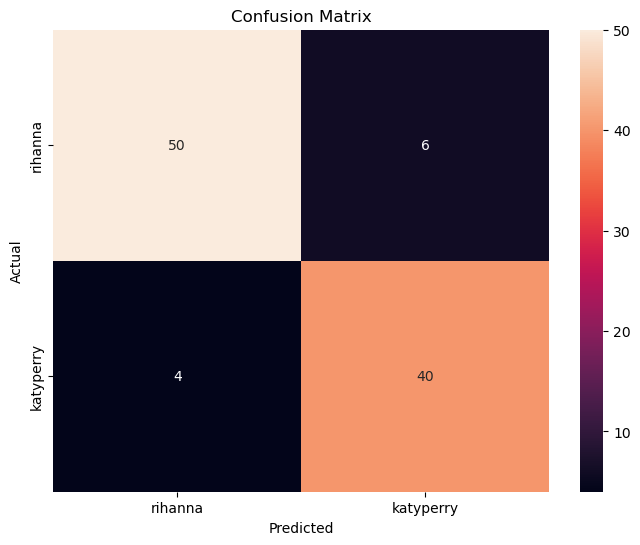

In [13]:
# Analyze results
if results:
    # Extract predictions and actual authors
    predicted_authors = [r[3] for r in results]
    actual_authors = [r[2] for r in results]
    
    # Calculate overall accuracy
    correct = sum(p == a for p, a in zip(predicted_authors, actual_authors))
    final_accuracy = correct / len(predicted_authors)
    print(f"Overall accuracy: {final_accuracy:.2%} ({correct}/{len(predicted_authors)})")
    
    # Find invalid predictions
    invalid_outputs = [(idx, pred, tweet) for idx, tweet, _, pred in results if pred not in ['rihanna', 'katyperry']]
    
    if invalid_outputs:
        print(f"\nNumber of invalid outputs: {len(invalid_outputs)}")
        print("Invalid predictions:")
        for idx, pred, tweet in invalid_outputs:
            print(f"Index {idx}: Prediction='{pred}' | Tweet='{tweet[:50]}...'")
            
    # Analyze per-author accuracy
    for author in ['rihanna', 'katyperry']:
        author_cases = [(p == author) for _, _, a, p in results if a == author]
        if author_cases:
            author_accuracy = sum(author_cases) / len(author_cases)
            print(f"\nAccuracy for {author}: {author_accuracy:.2%} ({sum(author_cases)}/{len(author_cases)})")
            
    # Create confusion matrix
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    # Filter out invalid predictions
    valid_results = [(a, p) for _, _, a, p in results if p in ['rihanna', 'katyperry']]
    if valid_results:
        y_true = [r[0] for r in valid_results]
        y_pred = [r[1] for r in valid_results]
        
        cm = confusion_matrix(y_true, y_pred, labels=['rihanna', 'katyperry'])
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=['rihanna', 'katyperry'], 
                    yticklabels=['rihanna', 'katyperry'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

In [15]:
# Qualitative analysis
# Convert results to DataFrame for easier handling
results_df = pd.DataFrame(results, columns=['idx', 'tweet_text', 'actual_author', 'predicted_author'])

# Find correct and incorrect predictions
correct_cases = results_df[results_df['actual_author'] == results_df['predicted_author']]
incorrect_cases = results_df[results_df['actual_author'] != results_df['predicted_author']]

# Sample a few from each
n_samples = 12
sampled_correct = correct_cases.sample(n=min(n_samples, len(correct_cases)), random_state=42)
sampled_incorrect = incorrect_cases.sample(n=min(n_samples, len(incorrect_cases)), random_state=42)

print("SOME CORRECTLY CLASSIFIED EXAMPLES:\n")
for _, row in sampled_correct.iterrows():
    print(f"Tweet: {row['tweet_text']}\nActual: {row['actual_author']} | Predicted: {row['predicted_author']}\n{'-'*60}")

print("\nSOME INCORRECTLY CLASSIFIED EXAMPLES:\n")
for _, row in sampled_incorrect.iterrows():
    print(f"Tweet: {row['tweet_text']}\nActual: {row['actual_author']} | Predicted: {row['predicted_author']}\n{'-'*60}")

SOME CORRECTLY CLASSIFIED EXAMPLES:

Tweet: @cher don't worry, honestly you can get back in the tub if you like, she's got this. ❤️ https://t.co/UqUfQ9OYm8
Actual: katyperry | Predicted: katyperry
------------------------------------------------------------
Tweet: 👼🏻 luminary fairy 👼🏻 @ Burning Man https://t.co/N2ENwLknBt
Actual: katyperry | Predicted: katyperry
------------------------------------------------------------
Tweet: she. + Rodarte http://t.co/9stYd5vest
Actual: rihanna | Predicted: rihanna
------------------------------------------------------------
Tweet: get this nigga @yusefhairnyc da phuck out my hou$e http://t.co/PvrpPPR2sr
Actual: rihanna | Predicted: rihanna
------------------------------------------------------------
Tweet: It's just beyond the vault. Discover room 7 of the #ANTIdiaRy at https://t.co/uJ0CLlhoaS https://t.co/povYOBn3Fm
Actual: rihanna | Predicted: rihanna
------------------------------------------------------------
Tweet: She. x Shoot day x Inez and

In [16]:
# Save results as html for qualitative analysis
sampled_correct['case'] = 'correct'
sampled_incorrect['case'] = 'incorrect'
qualitative_df = pd.concat([sampled_correct, sampled_incorrect])
# Save to the "data" folder
qualitative_df.to_html("./data/claude_qualitative_inspection.html", index=False)



In [25]:
# Ask Claude to explain the results

prompt = f"""
A Large Language Model was tasked with attributing authorship to tweets from Rihanna and Katy Perry.
Generally, the model performed well, with close to 90% accuracy. However, it made some mistakes.

You will be provided with:
1. A list of tweets from Rihanna and Katy Perry that were correctly classified by the model
2. A list of tweets from Rihanna and Katy Perry that were incorrectly classified by the model

Your task and guidelines:
Act as a linguistic expert. Your task is to explain the performance of the model. Think globally about the dataset and the discursive patterns that emerge. Give more focus/
in trying to understand the mistakes the model made.
Do not focus on individual tweets, but rather on the broader discursive patterns. Try, when possible, to use examples to illustrate those patterns.

Here are the tweets from Rihanna and Katy Perry that were correctly classified by the model:
<correct_cases>
{correct_cases['tweet_text'].to_string(index=False)}
</correct_cases>

Here are the tweets from Rihanna and Katy Perry that were incorrectly classified by the model:
<incorrect_cases>
{incorrect_cases['tweet_text'].to_string(index=False)}
</incorrect_cases>

Your answer should be a two to three paragraph explanation about the performance of the model, following the guidelines above.
"""

In [26]:
from IPython.display import display, HTML

qualitative_explanation = get_completion(prompt)
display(HTML(qualitative_explanation))
